In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [57]:
df = pd.read_csv('Supermart Grocery Sales.csv')

In [49]:
df.shape

(9994, 11)

In [11]:
df.describe()

,Sales,Discount,Profit
count,9994.000000,9994.000000,9994.000000
mean,1496.596158,0.226817,374.937082
std,577.559036,0.074636,239.932881
min,500.000000,0.100000,25.250000
25%,1000.000000,0.160000,180.022500
50%,1498.000000,0.230000,320.780000
75%,1994.750000,0.290000,525.627500
max,2500.000000,0.350000,1120.950000


In [12]:
df.duplicated().sum()

np.int64(0)

In [13]:
df.isnull().sum()

Order ID         0
Customer Name    0
Category         0
Sub Category     0
City             0
Order Date       0
Region           0
Sales            0
Discount         0
Profit           0
State            0
dtype: int64

In [58]:
# Safely convert 'Order Date' column to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='mixed', errors='coerce')



# Extract time-based features
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Week'] = df['Order Date'].dt.isocalendar().week
df['Day'] = df['Order Date'].dt.day
df['DayOfWeek'] = df['Order Date'].dt.dayofweek  # 0 = Monday
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6])

In [17]:
df.head()

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State,Year,Month,Week,Day,DayOfWeek,IsWeekend
0,OD1,Harish,Oil & Masala,Masalas,Vellore,2017-11-08,North,1254,0.12,401.28,Tamil Nadu,2017,11,45,8,2,False
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,2017-11-08,South,749,0.18,149.80,Tamil Nadu,2017,11,45,8,2,False
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,2017-06-12,West,2360,0.21,165.20,Tamil Nadu,2017,6,24,12,0,False
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,2016-10-11,South,896,0.25,89.60,Tamil Nadu,2016,10,41,11,1,False
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,2016-10-11,South,2355,0.26,918.45,Tamil Nadu,2016,10,41,11,1,False


In [167]:
df.drop('State', axis=1, inplace=True)

EDA

Text(0.5, 1.0, 'Sales Distribution')

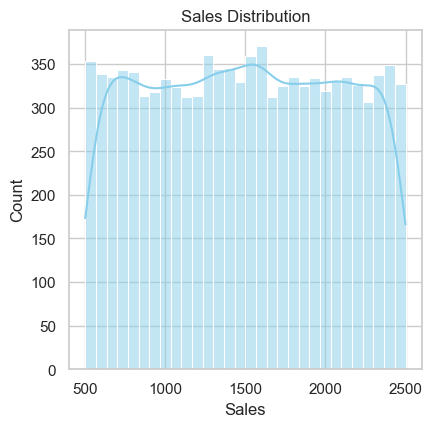

In [28]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 15))

plt.subplot(3, 2, 1)
sns.histplot(df['Sales'], bins=30, kde=True, color='skyblue')
plt.title('Sales Distribution')

Text(0.5, 1.0, 'Profit Distribution')

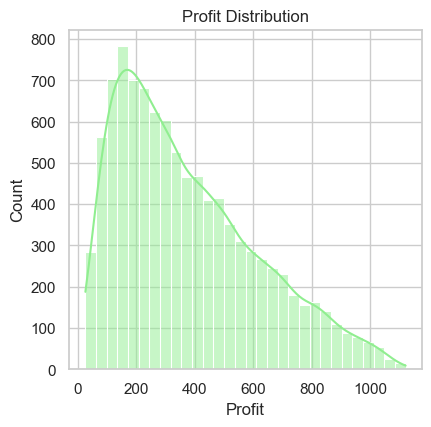

In [29]:
plt.figure(figsize=(10, 15))
plt.subplot(3, 2, 2)
sns.histplot(df['Profit'], bins=30, kde=True, color='lightgreen')
plt.title('Profit Distribution')


Text(0.5, 1.0, 'Correlation Heatmap')

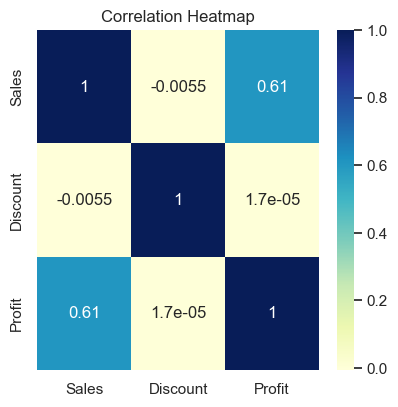

In [31]:
plt.figure(figsize=(10, 15))
plt.subplot(3, 2, 5)
corr = df[['Sales', 'Discount', 'Profit']].corr()
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.title('Correlation Heatmap')

PREDICTION FOR CATEGORY


In [82]:
print(df['Category'].value_counts())

Category
Snacks               1514
Eggs, Meat & Fish    1490
Fruits & Veggies     1418
Bakery               1413
Beverages            1400
Food Grains          1398
Oil & Masala         1361
Name: count, dtype: int64


In [229]:
df = df.drop(columns=[col for col in ['Order ID', 'Order Date'] if col in df.columns])

In [231]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['Sub Category', 'Customer Name', 'City', 'Region', 'DayOfWeek']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [111]:
df['Category'] = le.fit_transform(df['Category']) 

In [112]:
X = df.drop(columns=["Category"])
y = df["Category"]

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       283
           1       0.90      0.99      0.94       280
           2       0.94      0.88      0.91       298
           3       0.88      0.80      0.84       279
           4       0.75      0.87      0.80       284
           5       0.91      0.89      0.90       272
           6       0.99      0.91      0.95       303

    accuracy                           0.91      1999
   macro avg       0.91      0.91      0.91      1999
weighted avg       0.91      0.91      0.91      1999



PREDICTION FOR PROFIT

In [253]:
import sys
!{sys.executable} -m pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------------------------------ --- 1.3/1.5 MB 7.7 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.4 MB/s eta 0:00:00


In [4]:
# Load data


# Basic preprocessing
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df = df.dropna(subset=['Profit', 'Order Date'])

# Time features
df['Month'] = df['Order Date'].dt.month
df['DayOfWeek'] = df['Order Date'].dt.dayofweek
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

# Encode categorical features
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
for col in ['Sub Category', 'Category', 'City', 'Region']:
    df[col] = label_enc.fit_transform(df[col].astype(str))

# Feature engineering
df['HighDiscount'] = (df['Discount'] > 0.3).astype(int)
df['AvgSalesPerSubCat'] = df.groupby('Sub Category')['Sales'].transform('mean')
df['AvgProfitSubCat'] = df.groupby('Sub Category')['Profit'].transform('mean')

# Feature interactions
df['Sales_Discount'] = df['Sales'] * df['Discount']
df['Sales_Region'] = df['Sales'] * df['Region']

# Optional (if Quantity exists)
if 'Quantity' in df.columns:
    df['UnitPrice'] = df['Sales'] / (df['Quantity'] + 1e-5)
    use_quantity = True
else:
    use_quantity = False

# Final feature list
features = [
    'Sub Category', 'Category', 'City', 'Region',
    'Sales', 'Discount', 'Month', 'DayOfWeek',
    'HighDiscount', 'IsWeekend', 'AvgSalesPerSubCat',
    'AvgProfitSubCat', 'Sales_Discount', 'Sales_Region'
]

if use_quantity:
    features.append('Quantity')
    features.append('UnitPrice')

X = df[features]
y = np.log1p(df['Profit'])  # Log-transformed profit

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM
from xgboost import XGBRegressor
model = XGBRegressor(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.4,
    colsample_bytree=0.9,
    random_state=42
)
model.fit(X_train, y_train)

# Predict
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Reverse log

# Inverse transform y_test for evaluation
import numpy as np
y_test_actual = np.expm1(y_test)

# Evaluation
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2 = r2_score(y_test_actual, y_pred)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R² Score: {r2:.2f}")




✅ RMSE: 207.26
✅ R² Score: 0.23


PREDICTION FOR SALES

In [16]:
df.head()

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu


In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Bin 'Sales' into 3 classes for classification
df['Sales_Class'] = pd.qcut(df['Sales'], q=3, labels=[0, 1, 2], duplicates='drop')

# Encode categorical columns
label_cols = ['Category', 'Sub Category', 'City', 'Region', 'State', 'Customer Name']
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Define features and target
X = df[['Category', 'Sub Category', 'City', 'Region', 'Discount', 'Profit', 'State']]
y = df['Sales_Class'].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Classifier
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    eval_metric='mlogloss',
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5487743871935968

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.82      0.65       666
           1       0.45      0.37      0.41       662
           2       0.71      0.46      0.56       671

    accuracy                           0.55      1999
   macro avg       0.56      0.55      0.54      1999
weighted avg       0.57      0.55      0.54      1999



SUB CATEGORY PREDICTION

In [67]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt




df['SalesBin'] = pd.qcut(df['Sales'], q=3, labels=[0, 1, 2], duplicates='drop')
df['SalesBin'] = df['SalesBin'].astype(int)

# Convert 'Order Date' to datetime and extract features
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Month'] = df['Order Date'].dt.month
df['DayOfWeek'] = df['Order Date'].dt.dayofweek

# Encode categorical columns
label_cols = ['Category', 'Sub Category', 'City', 'Region', 'State', 'Customer Name']
for col in label_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Define features and target
X = df[['Category', 'Sub Category', 'City', 'Region', 'Discount', 'State', 'Month', 'DayOfWeek']]
y = df['SalesBin'].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost classifier
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    eval_metric='mlogloss',
    random_state=42
)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))




Accuracy: 0.34967483741870936

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.32      0.33       666
           1       0.36      0.36      0.36       662
           2       0.35      0.37      0.36       671

    accuracy                           0.35      1999
   macro avg       0.35      0.35      0.35      1999
weighted avg       0.35      0.35      0.35      1999

